In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from Aux2 import *
import NMRAux as nmr
import Layers as ly

from torchinfo import summary

import torch as th
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset,DataLoader
from safetensors.torch import load_model
#from torchvision.models import googlenet

#from collections.abc import Callable
from tqdm.notebook import trange, tqdm

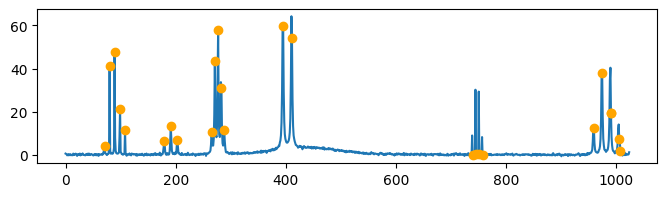

In [2]:
yy, res = nmr.generateRandomSpectrum(0)
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(yy["true"])
ax.scatter(res,[yy["true"][i] for i in res], c = "orange", zorder = 10)

In [7]:
ML = 10000
ML_test = 500
batch_size = 512
train_set = NMRDataset(maxLen = ML)
test_set = NMRDataset(maxLen = ML_test, startSeed = ML)

train_loader: DataLoader = DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=False,
    num_workers=2
)
test_loader: DataLoader = DataLoader(
    dataset=test_set,  batch_size=batch_size, shuffle=False,
    num_workers=2
)

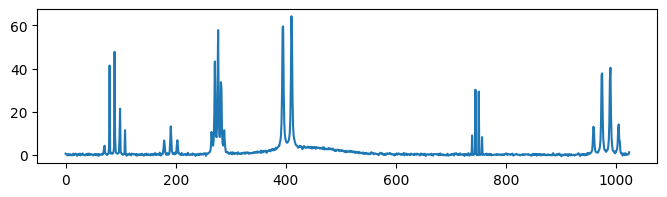

In [8]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(train_set[0][0].T)

In [9]:
# Let's detect and select the most appropriate device
# (adapt it to your specific hardware needs: mps, tpu, ...)
device: th.device = th.device(
    "cuda" if th.cuda.is_available() else "cpu"
)

In [10]:
model: th.nn.Module = NMRSeq().to(device)
summary(model, input_size=(batch_size,1,nmr.nPts))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [512, 1, 1024]            --
├─Inception_variant: 1-1                 [512, 136, 1024]          --
│    └─Inception_piece: 2-1              [512, 16, 1024]           --
│    │    └─Conv1d: 3-1                  [512, 1, 1025]            3
│    │    └─Conv1d: 3-2                  [512, 16, 1024]           48
│    └─Inception_piece: 2-2              [512, 32, 1024]           --
│    │    └─Conv1d: 3-3                  [512, 1, 1027]            5
│    │    └─Conv1d: 3-4                  [512, 32, 1024]           160
│    └─Inception_piece: 2-3              [512, 64, 1024]           --
│    │    └─Conv1d: 3-5                  [512, 1, 1031]            9
│    │    └─Conv1d: 3-6                  [512, 64, 1024]           576
│    └─Inception_piece: 2-4              [512, 16, 1024]           --
│    │    └─Conv1d: 3-7                  [512, 1, 1055]            33
│    │    └─Conv

In [11]:
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=0.001, weight_decay=0
)

#lossCriterion = nn.MSELoss()
lossCriterion = nn.CrossEntropyLoss()

In [12]:
EPOCHS = 100
BATCH_SIZE = 32

'''
# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training
    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):
        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = model(x)
        loss = lossCriterion(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    model.eval()  # Remember to set the model in evaluation mode before evaluating it
    
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = model(x_e)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += lossCriterion(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)
'''

'\n# Loop over epochs\nfor epoch in trange(EPOCHS, desc="Training epoch"):\n\n    model.train()  # Remember to set the model in training mode before actual training\n    # Loop over data\n    for batch_idx, batched_datapoint in enumerate(train_loader):\n        x, y = batched_datapoint\n        x, y = x.to(device), y.to(device)\n\n        # Forward pass + loss computation\n        yhat = model(x)\n        loss = lossCriterion(yhat, y)\n\n        # Zero-out past gradients\n        optimizer.zero_grad()\n\n        # Backward pass\n        loss.backward()\n\n        # Update model parameters\n        optimizer.step()\n\n    model.eval()  # Remember to set the model in evaluation mode before evaluating it\n\n    num_elem: int = 0\n    trackingmetric: float = 0\n    trackingcorrect: int = 0\n\n    # Since we are just evaluating the model, we don\'t need to compute gradients\n    with th.no_grad():\n        # ... by looping over training data again\n        for _, batched_datapoint_e in enum

In [37]:
load_model(model, "./modelpars.safetensors")

(set(), set())

In [49]:
crit = []
with th.no_grad():
        # ... by looping over training data again
    for _, batched_datapoint in enumerate(tqdm(train_loader)):
        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)
        target = model(x)
        crit.append(lossCriterion(target, y))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [53]:
y

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.